## Generate Initial Parameters
We are going to pass our synthetic data on cells from the [CAMP dataset](https://doi.org/10.18126/fdxq-7yul).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moirae.models.ecm.components import Resistance, OpenCircuitVoltage, MaxTheoreticalCapacity, ReferenceOCV
from moirae.models.ecm import ECMASOH
from batdata.data import BatteryDataset
from scipy.interpolate import interp1d
from shutil import copyfileobj
from pathlib import Path
import numpy as np
import requests

Configuration

In [2]:
data_url = 'https://data.materialsdatafacility.org/mdf_open/camp_2023_v3.5/hdf5/refined/batch_B28A_cell_39.h5'
template_dir = Path('template-data')  # Where to store the template data
num_soc_steps: int = 9  # Number of interpolation steps in the OCV measurement

## Download and Parse the Data
Download the data using HTTP and store locally

In [3]:
data_path = template_dir / data_url.split("/")[-1]
print(f'Saving data to {data_path}')

Saving data to template-data\batch_B28A_cell_39.h5


Download if not present

In [4]:
if not data_path.exists():
    with data_path.open('wb') as fp:
        copyfileobj(requests.get(data_url, stream=True).raw, fp)

In [5]:
template_dataset = BatteryDataset.from_batdata_hdf(data_path)

## Get Initial Parameter Estimates for Equivalent Circuit Parameters
Let's start with some educated guesses for the parameters. 

First up, make a model for the open circuit voltage using a regular cycle

In [6]:
initial_cycles = template_dataset.raw_data.query('24 < cycle_number < 40')  # Get cycles after some initial tests

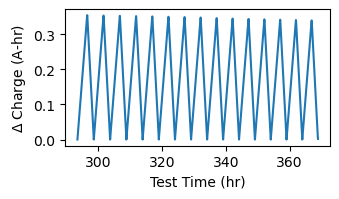

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, -initial_cycles['cycle_capacity'])

ax.set_xlabel('Test Time (hr)')
ax.set_ylabel('$\Delta$ Charge (A-hr)')
fig.tight_layout()

Estimate a capacity by getting the maximum amount of energy added to the battery

In [8]:
cycle_capacities = -initial_cycles.groupby('cycle_number')['cycle_capacity'].min()
cycle_capacities.describe()

count    15.000000
mean      0.346770
std       0.004931
min       0.339110
25%       0.342624
50%       0.347348
75%       0.350804
max       0.353956
Name: cycle_capacity, dtype: float64

In [9]:
initial_capacity = cycle_capacities.median()
print(f'Initial capacity estimate is {initial_capacity:.2f} A-hr')

Initial capacity estimate is 0.35 A-hr


Estimate the Open Circuit Voltage by measuring the voltage at different states of charge during both charge and discharge

In [10]:
discharging = initial_cycles.query('state == "discharging"')
charging = initial_cycles.query('state == "charging"')

In [11]:
def get_voltage_measurments(subset):
    """Determine measurements at different SOCs"""

    voltage_steps = np.zeros((len(set(subset['cycle_number'])), num_soc_steps))
    for i, (_, group) in enumerate(subset.groupby('cycle_number')):
        group = group.sort_values('cycle_capacity')
        f = interp1d(-group['cycle_capacity'], group['voltage'])
        steps = np.linspace(
            -group['cycle_capacity'].max(), 
            -group['cycle_capacity'].min(),
            num_soc_steps
        )
        voltage_steps[i, :] = f(steps)
    return voltage_steps.mean(axis=0)

In [12]:
discharge_volt = get_voltage_measurments(discharging)
charge_volt = get_voltage_measurments(charging)
ocv = 0.5 * (discharge_volt + charge_volt)

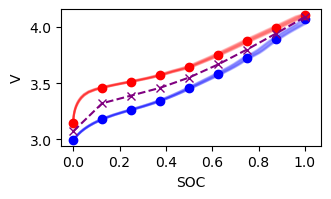

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

soc_values = np.linspace(0, 1, num_soc_steps)
for subset, points, color in [(discharging, discharge_volt, 'blue'), (charging, charge_volt, 'red')]:
    for gid, group in subset.groupby('cycle_number'):
        ax.plot(-group['cycle_capacity'] / initial_capacity, group['voltage'], alpha=0.1, color=color)
    ax.scatter(soc_values, points, marker='o', color=color)
ax.plot(soc_values, ocv, '--x', color='purple')

ax.set_xlabel('SOC')
ax.set_ylabel('V')
fig.tight_layout()

Estimate a SOC-dependent series resistance based on the difference in voltage between charge and discharge and the charge difference

$V_c - V_d = OCV + I_c R - (OCV - I_d R) = (I_c + I_d)R$

In [14]:
charge_current = charging['current'].abs().mean()
discharge_current = discharging['current'].abs().mean()
print(f'Charge current {charge_current:.1f} A. Discharge current {discharge_current:.1f} A')

Charge current 0.1 A. Discharge current 0.2 A


In [15]:
r_serial = (charge_volt - discharge_volt) / (discharge_current + charge_current)
r_serial /= 10  # The r0 estimate is too large because we're not including other sources of resistance

## Save Results
Assemble then save results as a [Moirae ECMASOH object](https://rovi-org.github.io/auto-soh/source/models.html#moirae.models.ecm.advancedSOH.ECMASOH).

In [16]:
asoh = ECMASOH(
    q_t=MaxTheoreticalCapacity(base_values=initial_capacity),
    r0=Resistance(base_values=r_serial),
    ocv=OpenCircuitVoltage(
        ocv_ref=ReferenceOCV(base_values=ocv, interpolation_style='cubic'),
        ocv_ent={'base_values': 0}
    )
)

In [17]:
with open('initial-asoh.json', 'w') as fp:
    print(asoh.model_dump_json(indent=True), file=fp)